# Synthetic Data Generation: Libraries Comparison

In this notebook we will compare two of the most prominent (open source) Python Packages for data generation: SDV and synthcity. The study will compare the creation of syntetic data from single table, and therefore creating single table as output.
Moreover, I'll create a small Generative Adversarial Network to create synthetic data and compare this simple model with the state-of-art models.

First of all, let's import all the needed libraries.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, wasserstein_distance
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import Metadata
from synthcity.plugins import Plugins

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


Let's start by importing the data we'll use (Electric Consumption Household)

In [2]:
# Importing the training dataset that we will use to create syntethic data
df = pd.read_csv("Datasets/energydata_complete.csv", nrows=10000) # Taking only the first 10.000 rows for memory limitation

# Inspect data 
print(df.head())

              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    9

Inspecting the data (Handling missing values)

In [3]:
# Missing values
miss_info = df.isnull().sum()

treshold = 0.5 * len(df)
missing_column_count = 0
for col, missing_count in miss_info.items():
    if missing_count > treshold:
        missing_column_count += 1
        
print(f"There are {missing_column_count} columns with more than {int(treshold)} missing values")

# Drop these features
df = df.dropna(axis=1, thresh=treshold)
print(df.head())
print(df.isnull().sum().sum())

There are 0 columns with more than 5000 missing values
              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspee

Let's visualize the distribution of energy consumption present in the dataset (Recorded every 10 minutes)

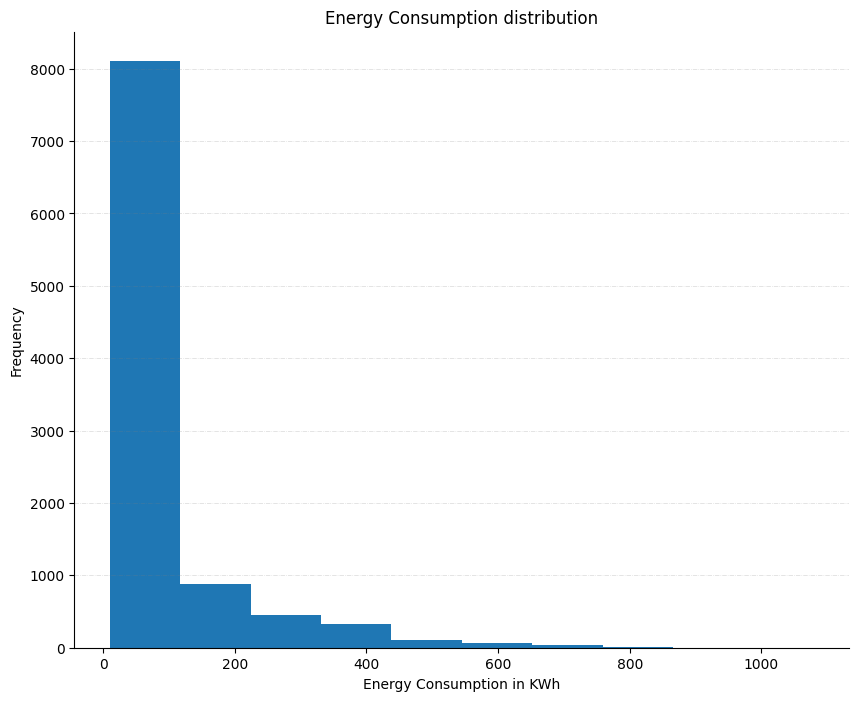

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist(df["Appliances"])
ax.set_xlabel("Energy Consumption in KWh")
ax.set_ylabel("Frequency")
ax.set_title("Energy Consumption distribution")
ax.grid(visible=True, color="grey", linestyle="-.", linewidth=0.5, alpha=0.3, axis="y")
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False) 
plt.show()

Now let's start by analyzing the first package: SDV. To use this package correctly we should first create the metadata for the current dataset. This metadata will then be used in the creation of the synthetic data.

In [5]:
# Create Metadata
metadata = Metadata.detect_from_dataframe(
    data=df,
    table_name="Energy_consumption")

print(metadata)

{
    "tables": {
        "Energy_consumption": {
            "columns": {
                "date": {
                    "sdtype": "datetime",
                    "datetime_format": "%m/%d/%Y %H:%M"
                },
                "Appliances": {
                    "sdtype": "numerical"
                },
                "lights": {
                    "sdtype": "categorical"
                },
                "T1": {
                    "sdtype": "numerical"
                },
                "RH_1": {
                    "sdtype": "numerical"
                },
                "T2": {
                    "sdtype": "numerical"
                },
                "RH_2": {
                    "sdtype": "numerical"
                },
                "T3": {
                    "sdtype": "numerical"
                },
                "RH_3": {
                    "sdtype": "numerical"
                },
                "T4": {
                    "sdtype": "numerical"
                

After creating the metadata we can create the syntethizer. This is the description of a synthetizer that can be found in the SDV documentation page: 

"The SDV creates synthetic data using machine learning. A synthesizer is an object that you can use to accomplish this task.

1. You'll start by creating a synthesizer based on your metadata

2. Next, you'll train the synthesizer using real data. In this phase, the synthesizer will learn patterns from the real data.

2. Once your synthesizer is trained, you can use it to generate new, synthetic data."

There are different type of synthesizer, Each synthesizer uses a different machine learning technique for training. In this study we will try:
- GaussianCopulaSynthesizer: The Gaussian Copula Synthesizer uses classic, statistical methods to train a model and generate synthetic data.
- CTGANSynthesizer: The CTGAN Synthesizer uses GAN-based, deep learning methods to train a model and generate synthetic data.
- TVAESynthesizer: The TVAE Synthesizer uses a variational autoencoder (VAE)-based, neural network techniques to train a model and generate synthetic data.

Let's start with GaussianCopulaSynthesizer.

In [6]:
# Create the synthesizer
synthesizer_gaussian_SDV = GaussianCopulaSynthesizer(metadata)

# Training
synthesizer_gaussian_SDV.fit(df)

# Syntetic data generation
synthetic_data_gaussian_SDV = synthesizer_gaussian_SDV.sample(num_rows=10000)
print(synthetic_data_gaussian_SDV)

# Save the data
synthetic_data_gaussian_SDV.to_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv", index=False)

KeyboardInterrupt: 

Next let's try the CTGANSynthesizer (This step will be performed in a separate Google Colab Notebook to take advantage of the Free GPU offered, the code can still be seen below. The synthetic data created by the CTGANSynthesizer will be directly imported later in the notebook)

In [ ]:
# Create the synthesizer
synthesizer_CTGAN = CTGANSynthesizer(metadata)
# Training
synthesizer_CTGAN.fit(df)

# Syntetic data generation
synthetic_data_CTGAN = synthesizer_CTGAN.sample(num_rows=10000)
print(synthetic_data_CTGAN)

# Save the data
synthetic_data_CTGAN.to_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv", index=False)

KeyboardInterrupt: 

Same process for the TVAESynthesizer.

In [ ]:
# Create the synthesizer
synthesizer_TVAE_SDV = TVAESynthesizer(metadata)

# Training
synthesizer_TVAE_SDV.fit(df)

# Syntetic data generation
synthetic_data_TVAE_SDV = synthesizer_TVAE_SDV.sample(num_rows=10000)

# Save the data
synthetic_data_TVAE_SDV.to_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv", index=False)

Before to compare the statistical similarity of the synthetic data to the real data "by hand", I will use some of the disgnostics and data validation functions that the SDV Package offers. For example let's start with the run_diagnostic function that should perfrom a basic validity check for each column and ensure that the structure of the dataset is preserved. Therefore, the score after running this function should be 100%, as stated in the documentation of the package.

In [ ]:
# Import the data created by the Three models (To not retrain the model everytime, and make the notebook run smothly)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")

print("Diagnostic Report for GaussianCopulaSynthesizer")
diagnostic_report_gaussian_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Diagnostic Report for CTGANSynthesizer")
diagnostic_report_CTGAN_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Diagnostic Report for TVAESynthesizer")
diagnostic_report_TVAE_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

Diagnostic Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 797.59it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 237.05it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1154.59it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 490.16it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1172.27it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 496.90it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



SDV also offer a function to create a data quality report that checks for statistical similarity between the real and the synthetic data. I will use this function to try and calculate the statistical similarity by hand.

In [ ]:
# Create the quality report for the three models
# Commented out to smoothing the notebook running
print("Quality Report for GaussianCopulaSynthesizer")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

# Save these results
quality_report_gaussian_SDV.save(filepath="Results_SDV/quality_report_gaussian.pkl")
quality_report_CTGAN_SDV.save(filepath="Results_SDV/quality_report_CTGAN.pkl")
quality_report_TVAE_SDV.save(filepath="Results_SDV/quality_report_TVAE.pkl")

Quality Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 246.47it/s]|
Column Shapes Score: 87.85%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 260.42it/s]|
Column Pair Trends Score: 97.29%

Overall Score (Average): 92.57%

Quality Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 273.51it/s]|
Column Shapes Score: 86.43%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 259.46it/s]|
Column Pair Trends Score: 91.92%

Overall Score (Average): 89.18%

Quality Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 254.56it/s]|
Column Shapes Score: 92.76%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 255.54it/s]|
Column Pair Trends Score: 96.72%

Overall Score (Average): 94.74%



Another feature offered by SDV is to visualize in 2D the data. This can help see what kind of patterns the synthetic data has learned, and identify differences between the real and synthetic data.

In [ ]:
# Plot for the GaussianCopulaSynthesizer
fig_gaussian_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_gaussian_SDV.show()

In [ ]:
# Plot for the CTGAN model
fig_CTGAN_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_CTGAN_SDV.show()

In [ ]:
# Plot for the TVAESynthesizer model
fig_TVAE_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_TVAE_SDV.show()

## Synthcity Generator

In [ ]:
# Check available models
print(Plugins().list())

# Create Bayesian Network Model (Comparison with SDV GaussianCopula)
synthesizer_bayes_net_SYN = Plugins().get("bayesian_network")
print("Model initialized Successfully")

# Train on real data (TRAIN ON GPU)
synthesizer_bayes_net_SYN.fit(df)

# Generate synthetic data
synthetic_data_bayes_net_SYN = synthesizer_bayes_net_SYN.generate(10000)
print(synthetic_data_bayes_net_SYN.head())

# Save the data
synthetic_data_bayes_net_SYN.to_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv", index=False)

# Model to compare
# GaussianCopula VS bayesian_network (Both probabilistic models)
# CTGAN VS ctgan (Exact match)
# TVAE VS tvae (Exact Match)

[2025-02-23T21:28:23.580456+0100][6460][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-02-23T21:28:23.604737+0100][6460][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


['timegan', 'great', 'rtvae', 'dummy_sampler', 'decaf', 'tvae', 'survae', 'privbayes', 'uniform_sampler', 'aim', 'image_cgan', 'fflows', 'survival_ctgan', 'adsgan', 'image_adsgan', 'timevae', 'ctgan', 'arf', 'ddpm', 'radialgan', 'survival_gan', 'pategan', 'survival_nflow', 'bayesian_network', 'dpgan', 'nflow', 'marginal_distributions']
Model initialized Successfully


KeyboardInterrupt: 

In [ ]:
# Create Conditional GAN (Comparison with SDV CTGAN)
synthesizer_ctgan_SYN = Plugins().get("ctgan")

# Train the model
synthesizer_ctgan_SYN.fit(df)

# Create and save the data
synthetic_data_ctgan_SYN = synthesizer_ctgan_SYN.generate(10000)
print(synthetic_data_ctgan_SYN.head())
synthetic_data_ctgan_SYN.to_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv", index=False)

In [ ]:
# Create Triplet-Based Variational Autoencoder (Comparison with SDV TVAE)
synthesizer_tvae_SYN = Plugins().get("tvae")

# Train the model
synthesizer_tvae_SYN.fit(df)

# Create synthetic and save them
synthetic_data_tvae_SYN = synthesizer_tvae_SYN.generate(10000)
print(synthetic_data_tvae_SYN.head())
synthetic_data_tvae_SYN.to_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv", index=False)

## COMPARE DATASETS STATISTICS

For the moment I used the built in functions provided by the package (SDV) itself. 

In [ ]:
# Import all the necessary datasets
real_df = pd.read_csv("Datasets/energydata_complete.csv", nrows=10000)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")
synthetic_data_bayes_net_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv")
synthetic_data_ctgan_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv")
synthetic_data_tvae_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv")

# Evaluate quality with SDV built in package
print("Quality Report for GaussianCopulaSynthesizer SDV")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer SDV")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer SDV")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)


Quality Report for GaussianCopulaSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 265.47it/s]|
Column Shapes Score: 87.85%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 271.99it/s]|
Column Pair Trends Score: 97.29%

Overall Score (Average): 92.57%

Quality Report for CTGANSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 282.57it/s]|
Column Shapes Score: 86.43%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 269.64it/s]|
Column Pair Trends Score: 91.92%

Overall Score (Average): 89.18%

Quality Report for TVAESynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 294.28it/s]|
Column Shapes Score: 92.76%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 262.85it/s]|
Column Pair Trends Score: 96.72%

Overall Score (Average): 94.74%



In [ ]:
print("Quality Report for Bayesian Network SYN")
quality_report_bayes_net_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_bayes_net_SYN,
    metadata=metadata
)

print("Quality Report for ctgan SYN")
quality_report_ctgan_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_ctgan_SYN,
    metadata=metadata
)

print("Quality Report for tvae SYN")
quality_report_tvae_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_tvae_SYN,
    metadata=metadata
)

Quality Report for Bayesian Network SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 205.49it/s]|
Column Shapes Score: 75.46%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 264.66it/s]|
Column Pair Trends Score: 88.31%

Overall Score (Average): 81.88%

Quality Report for ctgan SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 272.25it/s]|
Column Shapes Score: 71.32%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 256.59it/s]|
Column Pair Trends Score: 86.36%

Overall Score (Average): 78.84%

Quality Report for tvae SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 274.74it/s]|
Column Shapes Score: 69.42%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 271.47it/s]|
Column Pair Trends Score: 86.65%

Overall Score (Average): 78.04%



Create a standard function to evaluate stastical similarity between real and synthetic data.

In [ ]:
# Create the function
def overall_similarity(real_df, synthetic_df, 
                       weight_mean=0.3, weight_median=0.2, weight_mode=0.1, weight_sd=0.1, weight_var=0.1,
                       weight_ks=0.2, weight_wasserstein=0.1):
    """
    Computes an overall similarity score between real and synthetic datasets based
    on normalized differences in mean, median (if numerical) and mode (if categorical) across columns.

    Parameters:
    real_df (pd.DataFrame): Real dataset
    synthetic_df (pd.DataFrame): Synthetic dataset
    weight_mean (float, optional): Weight for mean difference. Defaults to 0.3.
    weight_median (float, optional): Weight for median difference. Defaults to 0.3.
    weight_mode (float, optional): Weight for mode difference. Defaults to 0.2.
    weight_sd (float, optional): Weight for standard deviation difference. Defaults to 0.1
    weight_var (float, optional): Weight for variance difference. Defaults to 0.1

    Returns:
    Returns a score between 0 and 100, where 100 indicates perfect similarity.
    """

    # Drop datetime columns
    real_df = real_df.select_dtypes(exclude=["datetime64"])
    synthetic_df = synthetic_df.select_dtypes(exclude=["datetime64"])

    scores = []
    common_cols = set(real_df.columns).intersection(set(synthetic_df.columns))

    for col in common_cols:
        # Check if numerical
        if pd.api.types.is_numeric_dtype(real_df[col]):
            # Classic statistics
            real_mean, syn_mean = real_df[col].mean(), synthetic_df[col].mean() 
            real_median, syn_median = real_df[col].median(), synthetic_df[col].median()
            real_sd, syn_sd = real_df[col].std(), synthetic_df[col].std()
            real_var, syn_var = real_df[col].var(), synthetic_df[col].var()
            
            # Avoid division by zero
            norm_mean = min(1, abs(real_mean - syn_mean) / (abs(real_mean) + 1e-6))
            norm_median = min(1, abs(real_median - syn_median) / (abs(real_median) + 1e-6))
            norm_sd = min(1, abs(real_sd - syn_sd) / (abs(real_sd) + 1e-6))
            norm_var = min(1, abs(real_var - syn_var) / (abs(real_var) + 1e-6))
      
            # Kolomogorov-Smirnov Test (Checks if distributions are similar)
            ks_stat, _ = ks_2samp(real_df[col].dropna(), synthetic_df[col].dropna())
        
            # Wasserstein Distance (Lower means closer distributions)
            wasserstein_dist = wasserstein_distance(real_df[col].dropna(), synthetic_df[col])
            norm_wasserstein = 1 / (1 + wasserstein_dist) # now between 0 and 1

            col_score = 1 - (weight_mean * norm_mean + 
                             weight_median * norm_median + 
                             weight_sd * norm_sd + 
                             weight_var * norm_var +
                             weight_ks * ks_stat + 
                             weight_wasserstein * (1 - norm_wasserstein))
        
        else:
            real_mode = real_df[col].mode()
            syn_mode = synthetic_df[col].mode()
            if not real_mode.empty and not syn_mode.empty:
                mode_score = 1.0 if real_mode.iloc[0] == syn_mode.iloc[0] else 0.0
            else:
                mode_score = 0.0
            col_score = mode_score* weight_mode
        
        scores.append(col_score)
    
    overall_score = np.mean(scores) * 100
    return round(overall_score, 2)


Evaluate the datasets based on this function

In [ ]:
sim_score_gaussian_SDV = overall_similarity(real_df, synthetic_data_gaussian_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Gaussian SDV: ", sim_score_gaussian_SDV)

sim_score_CTGAN_SDV = overall_similarity(real_df, synthetic_data_CTGAN_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SDV: ", sim_score_CTGAN_SDV)

sim_score_TVAE_SDV = overall_similarity(real_df, synthetic_data_TVAE_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SDV: ", sim_score_TVAE_SDV)

sim_score_bayes_net_SYN = overall_similarity(real_df, synthetic_data_bayes_net_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Bayes Net SYN: ", sim_score_bayes_net_SYN)

sim_score_ctgan_SYN = overall_similarity(real_df, synthetic_data_ctgan_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SYN: ", sim_score_ctgan_SYN)

sim_score_tvae_SYN =  overall_similarity(real_df, synthetic_data_tvae_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SYN: ", sim_score_tvae_SYN)

Similarity between real data and synthetic data with Gaussian SDV:  91.87
Similarity between real data and synthetic data with CTGAN SDV:  83.55
Similarity between real data and synthetic data with TVAE SDV:  91.92
Similarity between real data and synthetic data with Bayes Net SYN:  80.69
Similarity between real data and synthetic data with CTGAN SYN:  79.19
Similarity between real data and synthetic data with TVAE SYN:  78.59
